## Model overfits and does not generalize well to chimp calls outside the dataset

### Augmentation 

Create the augmented files and extract mfccs

In [1]:
# required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import librosa
import librosa.display
import soundfile as sf
from scipy.io import wavfile as wav
import IPython.display as ipd
import gammatone
import feature_utils
import pickle
import timeit
import random
from pydub import AudioSegment

d:\installfiles\python\python37\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# required 
def getListOfFiles(dirpath):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirpath)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirpath, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)        
    
    return allFiles

def urban_labels(Y, fpaths):
    """urban sound dataset labels."""
    urban_label = lambda path: int(os.path.split(path)[-1].split('-')[1])
    for p in fpaths:
        Y = np.append(Y, [urban_label(p)])
    return Y

In [3]:
#required
#path to the converted files
DATASET_16BIT_PATH = "E:/ChanuThesis/ProcessedSounds/UrbanSound8K-16bit/audioclassified"
AMP_NORMALIZED_PATH = "E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Amplitude_normalized"

filepaths = np.asarray(getListOfFiles(AMP_NORMALIZED_PATH))
print("No of entries in our Dataset: ", filepaths.shape)

Y = np.ndarray(0)
labels = urban_labels(Y, filepaths)
print("Labels : ",labels.shape)

with open("filepaths.txt", "wb") as fp:   #Pickling
    pickle.dump(filepaths, fp)
    
with open("labels.txt", "wb") as fp:   #Pickling
    pickle.dump(labels, fp)

No of entries in our Dataset:  (9542,)
Labels :  (9542,)


In [9]:
sound = AudioSegment.from_file(filepaths[4], "wav")

In [8]:
sound.dBFS

-30.17112454023635

In [9]:
#Getting average amplitude of all files to normalize
# required
Amplitudes = []

for i in range(len(filepaths)):
#for i in range(len(filepaths)):
    sound = AudioSegment.from_file(filepaths[i], 'wav')
    Amplitudes.append(sound.dBFS)


target_amplitude = sum(Amplitudes)/len(Amplitudes)

In [4]:
target_amplitude = -30.212114862008875

In [7]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)



In [9]:
# SRC_PATH = "E:/ChanuThesis/Raw sounds/Chimp_Youtube_4 sec chunks-20190926T031337Z-001/Chimp_youtube_11kSR_16bit_mono"
# DST_PATH = "E:/ChanuThesis/Raw sounds/Chimp_Youtube_4 sec chunks-20190926T031337Z-001/Amplitude_normalized"
# filepaths = np.asarray(getListOfFiles(SRC_PATH))




In [11]:
# for i in range(len(filepaths)):
#     sound = AudioSegment.from_file(filepaths[i], "wav")
#     normalized_sound = match_target_amplitude(sound, target_amplitude)
#     normalized_sound.export(os.path.join(DST_PATH,os.path.basename(os.path.normpath(filepaths[i]))) , format="wav")
    

0.002


In [10]:
import nlpaug.augmenter.audio as naa

def augmentation(data):
    

    #change loudness by a random factor between 0.5 and 2
    i = random.randint(0,1)
    if i == 1:
        aug1 = naa.LoudnessAug(loudness_factor=(0.5, 2))
        data = aug1.augment(data)
    
    #add noise
    i = random.randint(0,1)
    if i == 1:
        aug2 = naa.NoiseAug(noise_factor=round(random.uniform(0.001, 0.01), 3))
        data = aug2.augment(data)
    
    #manipulate pitch
    i = random.randint(0,1)
    if i == 1:
        aug3 = naa.PitchAug(sampling_rate=11025, pitch_range=(-5,5))
        data = aug3.augment(data)
    
    #time shift    
#     aug4 = naa.ShiftAug(sampling_rate=11025)
#     shifted = aug4.augment(pitched)
    
    return(data)


In [11]:
AMP_NORMALIZED_PATH = "E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Amplitude_normalized"
n_filepaths = np.asarray(getListOfFiles(AMP_NORMALIZED_PATH))
print("No of entries in our Dataset: ", n_filepaths.shape)

No of entries in our Dataset:  (9542,)


In [13]:
#caution
for i in range(len(n_filepaths)):
    data, sr = sf.read(n_filepaths[i])
    for j in range(6):
        output = augmentation(data)
        sf.write(os.path.join("E:/ChanuThesis/ASR-Chimps-master/ASR-Chimps-master/Augmented/","Aug"+str(j)+"R"+os.path.basename(os.path.normpath(n_filepaths[i]))), output, 11025, 'PCM_16')

In [14]:
def load_MFCCs(file_paths):
    mfccs = []
    mfccs.append(feature_utils.load_sound_mfccs(file_paths, 40))
    return mfccs

In [15]:
mfccsbase = load_MFCCs('E:/ChanuThesis/ProcessedSounds/UrbanSound8K-16bit/audioclassified/chimp_hoots/chimp_hoots-11-0 (1).wav')
print(mfccsbase[0])
print("For 20 channels: ", mfccsbase[0].shape)
#print("For 30 channels: ",mfccsbase[1].shape)
#print("For 40 channels: ",mfccsbase[2].shape)
#print("For 60 channels: ",mfccsbase[3].shape)

def singleMFCCexample():
    mfccsbase = load_MFCCs('E:/ChanuThesis/ProcessedSounds/UrbanSound8K-16bit/audioclassified/chimp_hoots/chimp_hoots-11-0 (1).wav')
print("Time taken for 1 file: ", timeit.timeit(singleMFCCexample, number=1))

[[-5.1628204e+02 -5.1902502e+02 -5.2714832e+02 ... -5.0899850e+02
  -5.3902686e+02 -6.6460645e+02]
 [ 4.6568726e+01  4.8248638e+01  4.8794746e+01 ...  5.5122692e+01
   6.2451973e+01  6.5346802e+01]
 [-1.5397709e+01 -1.2829280e+01 -1.6100780e+01 ... -1.8907703e+01
  -1.9611736e+01 -1.4064661e+01]
 ...
 [ 1.6460290e+00 -8.1244576e-01 -2.4740100e+00 ...  1.3831997e+00
  -2.7046442e-01  2.0064902e+00]
 [-1.3374913e+00 -1.9250124e+00 -3.8256874e+00 ...  4.7318239e+00
   7.0559187e+00  4.9671831e+00]
 [ 2.5583835e+00  4.5441985e-01  2.3998821e+00 ...  2.8002340e-01
   3.0648899e+00  2.2564120e+00]]
For 20 channels:  (40, 87)
Time taken for 1 file:  0.013088100000459235


In [4]:
#required
AUGMENTED_PATH = "E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented"
aug_filepaths = np.asarray(getListOfFiles(AUGMENTED_PATH))
print("No of entries in our Dataset: ", aug_filepaths.shape)

No of entries in our Dataset:  (57246,)


In [5]:
#AUG_PATH = "E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Amplitude_normalized"
mfcc_vectors = []
def generate_MFCCS():
    for i in range(len(aug_filepaths)):
    #for i in range(len(filepaths)):
        mfccsbase = load_MFCCs(aug_filepaths[i])
        for j in range(1):
            #11 sets of MFCCs for each file
            mfcc_vectors.append(mfccsbase[j])
        if i%300 == 0 :
            print("MFCCs loaded for :", aug_filepaths[i])

In [44]:
# caution
generate_MFCCS()
len(mfcc_vectors)

MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R100263-2-0-117.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R104998-7-14-5.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R111386-5-0-7.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R121285-0-0-7.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R132021-7-0-10.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R144007-5-0-3.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R149255-9-0-0.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R157648-8-0-0.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug0R159761-0-0-0.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmente

MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R207211-2-0-58.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R24364-4-0-1.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R39856-5-0-0.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R52171-3-6-1.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R60608-9-0-1.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R6902-2-0-18.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R7389-1-4-15.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R77751-7-9-2.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R89724-5-0-1.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug2R9950

MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug4Rdrilling-4-50.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug4Rsiren-8-5.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R104998-7-10-9.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R111386-5-0-2.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R121285-0-0-2.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R132016-9-0-16.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R144007-5-0-18.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R149254-9-0-29.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\Aug5R156869-8-0-9.wav
MFCCs loaded for : E:\ChanuThesis\ASR-Chimps-master\ASR-Chimps-master\Augmented\

57246

In [6]:

Y = np.ndarray(0)
labels = urban_labels(Y, aug_filepaths)
print("Labels : ",labels.shape)

Labels :  (57246,)


In [8]:
aug_filepaths[12345]
#labels[12345]

'E:\\ChanuThesis\\ASR-Chimps-master\\ASR-Chimps-master\\Augmented\\Aug1R168846-5-1-12.wav'

In [47]:
with open("Experiments/MFCCs_aug.txt", "wb") as fp:   #Pickling
    pickle.dump(mfcc_vectors, fp)
#del mfcc_vectors

In [9]:
X = np.array(pickle.load( open( "Experiments/MFCCs_aug.txt", "rb" ) ))
X.shape

(57246, 40, 87)

In [10]:

from sklearn.model_selection import train_test_split
XTrain,XTest,YTrain,YTest=train_test_split(X,labels,test_size=0.25)

from keras.utils import to_categorical

YTrain = np.array(to_categorical(YTrain, num_classes=12))
YTest = np.array(to_categorical(YTest, num_classes=12))

del X

Using TensorFlow backend.


In [11]:
XTrain[0].shape

(40, 87)

In [12]:
XTrain = XTrain.reshape(XTrain.shape[0], 40, 87, 1)
XTest = XTest.reshape(XTest.shape[0], 40, 87, 1)

np.savez('aug_data_h.npz', XTrain=XTrain, XTest=XTest, YTrain=YTrain, YTest=YTest)
print(XTrain.shape)
print(XTest.shape)

(42934, 40, 87, 1)
(14312, 40, 87, 1)


In [52]:
#del mfcc_vectors

In [13]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from keras.utils import np_utils
from sklearn import metrics

In [14]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=(40, 87, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [31]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 40, 87, 16)        80        
_________________________________________________________________
batch_normalization_9 (Batch (None, 40, 87, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 43, 16)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 43, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 20, 43, 32)        2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 10, 21, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 10, 21, 32)       

In [32]:
history = model.fit(np.array(XTrain), np.array(YTrain), batch_size=20, epochs=100, validation_data=(np.array(XTest), np.array(YTest)))
# list all data in history run for 300 epochs
print(history.history.keys())

Train on 42934 samples, validate on 14312 samples
Epoch 1/100
42934/42934 [==============================] - 43s 1ms/step - loss: 2.1589 - accuracy: 0.2271 - val_loss: 1.7531 - val_accuracy: 0.4261
Epoch 2/100
42934/42934 [==============================] - 47s 1ms/step - loss: 1.8845 - accuracy: 0.3078 - val_loss: 1.5436 - val_accuracy: 0.5045
Epoch 3/100
42934/42934 [==============================] - 46s 1ms/step - loss: 1.7056 - accuracy: 0.3765 - val_loss: 1.4080 - val_accuracy: 0.5463
Epoch 4/100
42934/42934 [==============================] - 52s 1ms/step - loss: 1.5124 - accuracy: 0.4534 - val_loss: 1.1922 - val_accuracy: 0.5978
Epoch 5/100
42934/42934 [==============================] - 45s 1ms/step - loss: 1.3962 - accuracy: 0.5000 - val_loss: 1.1023 - val_accuracy: 0.6339
Epoch 6/100
42934/42934 [==============================] - 53s 1ms/step - loss: 1.3313 - accuracy: 0.5252 - val_loss: 1.0352 - val_accuracy: 0.6544
Epoch 7/100
42934/42934 [==============================] - 46s

42934/42934 [==============================] - 36s 842us/step - loss: 0.7886 - accuracy: 0.7238 - val_loss: 0.6381 - val_accuracy: 0.7967
Epoch 56/100
42934/42934 [==============================] - 33s 773us/step - loss: 0.7729 - accuracy: 0.7279 - val_loss: 0.5738 - val_accuracy: 0.8168
Epoch 57/100
42934/42934 [==============================] - 33s 765us/step - loss: 0.7767 - accuracy: 0.7243 - val_loss: 0.6479 - val_accuracy: 0.8013
Epoch 58/100
42934/42934 [==============================] - 36s 829us/step - loss: 0.7710 - accuracy: 0.7287 - val_loss: 0.6214 - val_accuracy: 0.8028
Epoch 59/100
42934/42934 [==============================] - 34s 797us/step - loss: 0.7773 - accuracy: 0.7266 - val_loss: 0.6366 - val_accuracy: 0.7943
Epoch 60/100
42934/42934 [==============================] - 34s 788us/step - loss: 0.7680 - accuracy: 0.7299 - val_loss: 0.6391 - val_accuracy: 0.8011
Epoch 61/100
42934/42934 [==============================] - 34s 786us/step - loss: 0.7687 - accuracy: 0.728

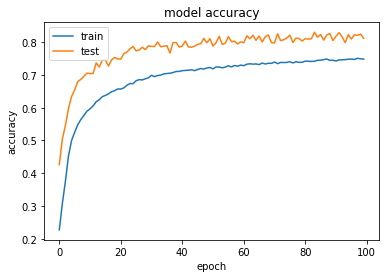

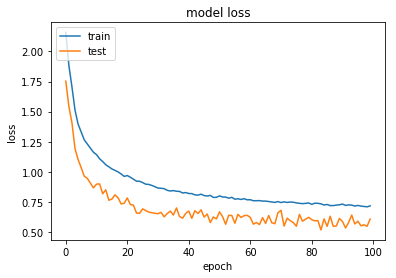

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
model.save("Experiments/AUG_model.h5")

In [15]:
model = load_model("Experiments\AUG_model.h5")

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Test Set Metrics
Y_test = np.argmax(YTest, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(XTest)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.91      0.74      1529
           1       0.91      0.87      0.89       389
           2       0.90      0.79      0.84      1528
           3       0.97      0.82      0.89      1168
           4       0.88      0.77      0.82      1351
           5       0.84      0.84      0.84      1449
           6       0.85      0.94      0.89       212
           7       0.73      0.87      0.79      1368
           8       0.97      0.87      0.92      1391
           9       0.93      0.80      0.86      1493
          10       0.89      0.94      0.91      1698
          11       0.92      0.71      0.80       736

    accuracy                           0.84     14312
   macro avg       0.87      0.84      0.85     14312
weighted avg       0.86      0.84      0.84     14312

[[1390    1   14    4    8   30    0   56    0   26    0    0]
 [   9  339    0    0   14    5    0   18    0    4    0    0]
 [ 119 

In [17]:
class_names = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music','chimp_shriek','chimp_hoot']

Confusion matrix, without normalization
[[1390    1   14    4    8   30    0   56    0   26    0    0]
 [   9  339    0    0   14    5    0   18    0    4    0    0]
 [ 119    1 1204   13   22   61    6   49    8   40    4    1]
 [  74    0   39  963   19   30   10   13    7   10    3    0]
 [  70    3    7    5 1035   40    8  176    3    0    4    0]
 [ 191    0    2    2    3 1211    0   35    0    5    0    0]
 [   9    0    0    2    1    0  199    0    0    1    0    0]
 [ 159    0    0    0    7   18    0 1184    0    0    0    0]
 [  64    4   15    2   13   29    0   53 1207    1    3    0]
 [ 166   25   51    2   13   11    1   18    9 1196    1    0]
 [   0    0    1    3   25    2    9   20    3    3 1589   43]
 [   0    0    1    1   19    0    1    5    1    1  187  520]]
Normalized confusion matrix
[[9.09e-01 6.54e-04 9.16e-03 2.62e-03 5.23e-03 1.96e-02 0.00e+00 3.66e-02
  0.00e+00 1.70e-02 0.00e+00 0.00e+00]
 [2.31e-02 8.71e-01 0.00e+00 0.00e+00 3.60e-02 1.29e-02 0.00e+

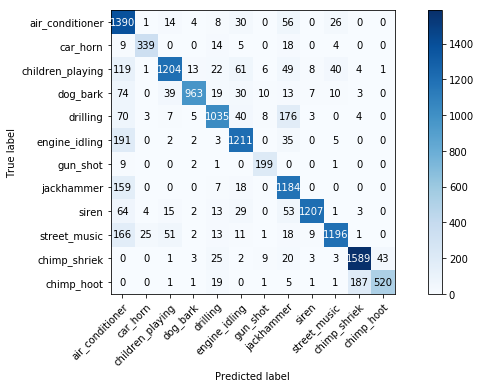

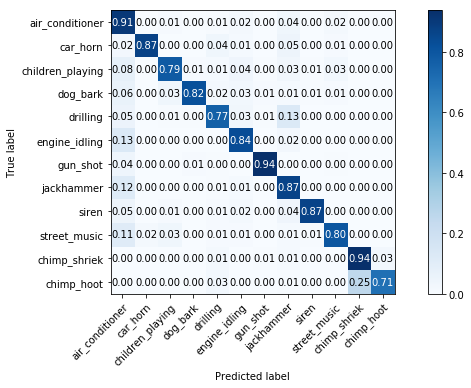

In [18]:


y_pred = model.predict_classes(XTest)
#classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(Y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(Y_test, y_pred)
    # Only use the labels that appear in the data
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.figure.set_size_inches(9.5, 5.5)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names,
                      title='')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names, normalize=True,
                      title='')

plt.show()

In [19]:
def load_sound_files(file_paths):

    X,sr = librosa.load(file_paths, sr=11025)
    #, res_type='kaiser_fast'
    #mfccs=np.mean(librosa.feature.mfcc(y=X,sr=sr,n_mfcc=40).T,axis=0)
    mfccs=librosa.feature.mfcc(y=X,sr=sr,n_mfcc=40)

    return mfccs

In [ ]:
for i in range(1,10):
    k = "E:/ChanuThesis/Raw sounds/Chimps_september/test_cases/test_cases_0{}.wav".format(i)

    inf=load_sound_files(k)

    inf = np.array(inf).reshape(1, 40, 87, 1)

    inf_pred = model.predict_proba(np.array(inf))
    print(i, model.predict_classes(np.array(inf)), max(inf_pred[0]))

In [21]:
for i in range(10,13):
    k = "E:/ChanuThesis/Raw sounds/Chimps_september/test_cases/test_cases_{}.wav".format(i)

    inf=load_sound_files(k)

    inf = np.array(inf).reshape(1, 40, 87, 1)

    inf_pred = model.predict_proba(np.array(inf))
    print(i, model.predict_classes(np.array(inf)), max(inf_pred[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'E:/ChanuThesis/Raw sounds/Chimps_september/test_cases/test_cases_10.wav'

In [100]:
for i in range(1,10):
    k = "E:/ChanuThesis/Raw sounds/Chimps_september/test_cases/test_cases_ ({}).wav".format(i)

    inf=load_sound_files(k)

    inf = np.array(inf).reshape(1, 40, 87, 1)

    inf_pred = model.predict_proba(np.array(inf))
    print(i, model.predict_classes(np.array(inf)), max(inf_pred[0]))

1 [10] 0.7337323
2 [10] 0.94153047
3 [10] 0.9928745
4 [10] 0.90028596
5 [10] 0.9202469
6 [10] 0.7960305
7 [10] 0.8904671
8 [10] 0.7011273
9 [11] 0.54133385
